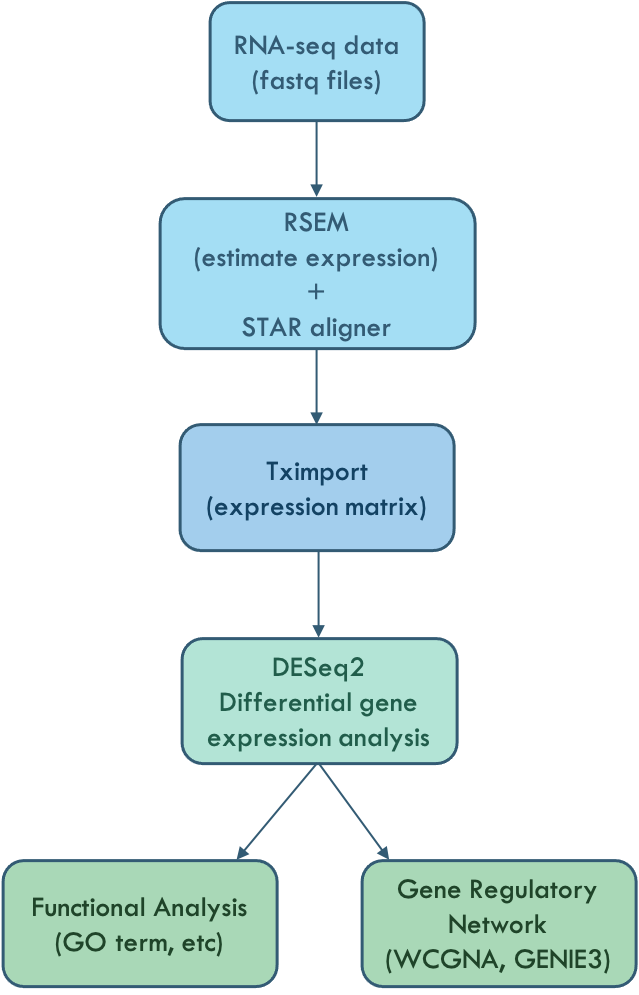

In [1]:
from IPython.display import Image
Image("workflow_proj.png")


## Extract data from RNA-seq to do DGE and further analysis with RSEM 

### RNA-seq fastq files located in separate folders by sample name 
C for Col0 WT, B for X mutant. First number 1,2,3 indicating replicate, second number #1-8 indicating condition of sample. 
(Ex. C11 is WT sample, replicate 1 in condition control environment.)

Uses Arabidopsis fasta sequence and gtf genome annotation files to build references suitable for RSEM to map RNA-seq reads with STAR aligner and extract data for gene counts, abundance, and length.


In [2]:
## shell script for running first step of RSEM - preparing references with STAR aligner

#!/bin/bash
#SBATCH --cpus-per-task=8
#SBATCH --time=10:00:00
#SBATCH --mem=64GB
#SBATCH --mail-type=START,END,FAIL
#SBATCH --job-name=REF
#SBATCH --output=slurm_log/%j_calc_expr_se.out
!module load intel/19.1.2
!module load rsem/intel/1.3.3
!module load python/intel/3.8.6
!module load star/intel/2.7.6a
!module load samtools/intel/1.14
!module load perl/intel/5.32.0
!module load htslib/intel/1.14

!rsem-prepare-reference --gtf ../../../ref/Arabidopsis_thaliana.TAIR10.49.gtf --star --star-path /share/apps/star/2.7.6a/intel/bin -p 8\
../../../ref/genome.fa AT_genome

/bin/bash: module: command not found
/bin/bash: module: command not found
/bin/bash: module: command not found
/bin/bash: module: command not found
/bin/bash: module: command not found
/bin/bash: module: command not found
/bin/bash: module: command not found
/bin/bash: rsem-prepare-reference: command not found


Input is RNAseq fastq files  (will input only read #1 for single end expression)
Reference name prefix is the folder path+prefix to the reference files generated from the previous step of RSEM (AT.genome)
Sample name prefix is also indicated so all outputs will be appropriately named (C11.genes.results, C11.isoforms.results, etc).

In [ ]:
## shell script for running second step of RSEM - calculate expression of single end reads from RNAseq with STAR aligner

#!/bin/bash
#SBATCH --cpus-per-task=8
#SBATCH --time=10:00:00
#SBATCH --mem=64GB
#SBATCH --mail-type=END,FAIL
#SBATCH --job-name=calc_expr_se
#SBATCH --output=slurm_log/%j_calc_expr_se.out
!module load intel/19.1.2
!module load rsem/intel/1.3.3
!module load python/intel/3.8.6
!module load star/intel/2.7.6a
!module load samtools/intel/1.14
!module load perl/intel/5.32.0
!module load htslib/intel/1.14
!set -x
!OUT_FILE_DIR=$1
!INPUT=$2
!REFERENCE_NAME_PREFIX=$3
!SAMPLE_NAME_PREFIX=$4
!rm -rf $OUT_FILE_DIR
!mkdir -p $OUT_FILE_DIR

!rsem-calculate-expression --keep-intermediate-files --star --star-gzipped-read-file --star-path /share/apps/star/2.7.6a/intel/bin -
p 8 --output-genome-bam\
 $INPUT\
 $REFERENCE_NAME_PREFIX\
 $SAMPLE_NAME_PREFIX

In [ ]:
## python script for running RSEM on all samples in parallel
module load parallel/20201022
parallel --colsep '\t' --header :\
 "sbatch /scratch/plant_stress/rsem/builtin_star/step2_calc_se/step2_calcse.sh {out_file_dir} {input} {reference_name_prefix} {sample_name_prefix}"\
 :::: "/scratch/plant_stress/rsem/builtin_star/step2_calc_se/rsem_calc_expr_se.tsv"

## R session to perform DGE analysis 

In [46]:
## load packages 
library(tximport)
library(readr)
library(BiocManager)
library(DESeq2)
library (ggplot2)
library(GenomeInfoDb)
library(dplyr)
library(tidyr)

### load details of data samples

### sample data (col data) for DGE

In [ ]:
###sampleData for DESeq2

## get sample names from original sample description file
## define 2 factors: genotype of sample (2 levels:WT, X mut) and treatment (4 levels: control, ...)
sampleData=data.frame(type=matrix(NA, nrow=nrow(samples)))
sampleData$sample= samples$"Fastq.file.name"
sampleData$type= ifelse(grepl("C", sampleData$sample), "WT", "X")
sampleData$treatment=sub('.*_', '', samples$Treatment.Name)

## change '+' in name to 'and'
sampleData$treatment=gsub("\\+","_and_",sampleData$treatment)
rownames(sampleData) <- conditions$"sample"

## remove B32 from sampleData (this sample has no fastq data)
sampleData=sampleData[!(row.names(sampleData) == "B32"), ]

### prepare df to be compatible with DESeq2

## indicate categories of data as factors
sampleData$type <- as.factor(sampleData$type)
sampleData$treatment <- as.factor(sampleData$treatment)

## define reference levels of data as WT and Control groups for type, treatment 
sampleData$type <- relevel(sampleData$type, ref = "WT")
sampleData$treatment <- relevel(sampleData$treatment, ref = "CT")

head(sampleData, 8)

### Import expression data with Tximport 

In [8]:
# import values from RSEM files with Tximport package into a single txi object

## file path of parent folder of RSEM files
folder_path= list.dirs("/scratch/plant_stress/rsem/builtin_star/step2_calc_se", full.names=T, recursive =T)

## get .genes.results files from the root folder path
files <- list.files(path = folder_path, pattern = "*.genes.results", full.names = TRUE)
names(files) = basename(dirname(files))

## import files
txi_all=tximport(files, type="rsem", txIn=FALSE, txOut=FALSE)


reading in files with read_tsv

1 
2 
3 
4 
5 
6 
7 
8 
9 
10 
11 
12 
13 
14 
15 
16 
17 
18 
19 
20 
21 
22 
23 
24 
25 
26 
27 
28 
29 
30 
31 
32 
33 
34 
35 
36 
37 
38 
39 
40 
41 
42 
43 
44 
45 
46 
47 




In [9]:
## import values from RSEM files of each condition with Tximport package into separate txi object for each condition *shown only for Control*

## file path of parent folder of RSEM files
folder_path= list.dirs("/scratch/plant_stress/rsem/builtin_star/step2_calc_se", full.names=T, recursive =T)

## find condition files from name of sample -- last number indicating condition
C_files= list.files(path=folder_path, pattern ="*1.genes.results", full.names = T)
names(C_files) = basename(dirname(C_files))

## use tximport to get txi obj for each condition 
txi_ctrl=tximport(C_files, type="rsem", txIn=FALSE, txOut=FALSE)


reading in files with read_tsv

1 
2 
3 
4 
5 
6 


reading in files with read_tsv

1 
2 
3 
4 
5 


reading in files with read_tsv

1 
2 
3 
4 
5 
6 


reading in files with read_tsv

1 
2 
3 
4 
5 
6 


reading in files with read_tsv

1 
2 
3 
4 
5 
6 


reading in files with read_tsv

1 
2 
3 
4 
5 
6 


reading in files with read_tsv

1 
2 
3 
4 
5 
6 


reading in files with read_tsv

1 
2 
3 
4 
5 
6 




### Prefiltering genes with no expression

In [ ]:
## function to remove genes with no expression (0 counts) -- 
# required to run DESeq2, prefiltering low expressed genes is not sufficient because genes with 0 transcript length can be retained

## check for rows (genes) with all zero counts (no exp) in all samples, define as zero_rows
remove_zero = function(txi){
  zero_rows = rowSums(txi$counts == 0) == ncol(txi$counts)
  print(sum(zero_rows))
  ##define txi excluding genes with 0 counts across all samples (zero_rows)
  txi$counts <- txi$counts[!zero_rows, ]
  txi$abundance <- txi$abundance[!zero_rows, ]
  txi$length <- txi$length[!zero_rows, ]
  
  return (txi)
}

## get list of all txi object (9 - 1 all condition txi + 8 individual condition txi) 
txi_list = mget(c("txi_all","txi_ctrl",...), envir = .GlobalEnv)

# Apply the function to each txi object in txi_list
txi_list = lapply(txi_list, remove_zero)

## Reassign the modified txi objects back to their original names 
list2env(txi_list, envir = .GlobalEnv)



### Filter lowly expressed gene

In order to avoid wide variability in the data (due to difference in gene expression in response to various stress treatment) which can result in large Log2FC between gene expression in WT vs mutant, we filter out lowly expressed genes in each condition and anlayze the remaining genes that intersect across all conditions. 

To do this we define a binary vector for each condition that classifies each gene as Keep True (1) OR Keep False (2). We find the genes intersected in all conditions with value 1 -- Keep True and extract the data from those genes from

In [ ]:
## remove low expression genes 
## making binary vector to identify genes to keep 

##doing it separate with A condition since it has 3 WT and 2 Mut samples - so smallest group size would be 2
## define df as the gene expression counts from txi_A 
## define keep_A vector to check if the total counts of each gene (rowSum) for at least 2 samples is at least 10 
## if the Keep condition of the gene is True, give it a value of 1, otherwise value 0
df = txi_A$counts
keep_A = as.vector(rowSums(df >= 10) >= 2)
names(keep_A)= row.names(df)
keep_A = ifelse(keep_A==T, 1,0)
head(keep_A) ### print top 6 genes in keep list 

## list of all txi obj (except txi_hl)
list_of_txi_treatments= list(txi_ctrl, ...)

## define list that will be binary keep vectors for all 8 conditions
keep_binary = list()

## loop through all txi in list and remove lowly exp genes
## check if the total counts of each gene (rowSum) for at least 3 samples is at least 10 
## if the Keep condition of the gene is True, give it a value of 1, otherwise value 0
for (i in 1:length(list_of_txi_treatments)) {
  df = list_of_txi_treatments[[i]]$counts
  keep_binary[[i]] = as.vector(rowSums(df >= 10) >= 3)
  names(keep_binary[[i]])= row.names(df)
  keep_binary[[i]] = ifelse(keep_binary[[i]]==T, 1,0)
}

## define names of each vector in keep_binary list as the name of the txi obj (from list of txi_treatments)
names(keep_binary) = names(list_of_txi_treatments)

## add txi_A to txi list and keep_A vector to keep_binary list
keep_binary$txi_A = keep_A
list_of_txi_treatments$txi_A = txi_A


## each txi obj has different number of genes -- find genes intersected in all (common)
common_genes= Reduce(intersect, lapply(list_of_txi_treatments, function(x) rownames(x$counts)))
print(length(common_genes)) ## print all common genes -- 22804

## extract those common genes from the binary matrix 
keep_common = lapply(keep_binary, function(x) x[common_genes])
keep_common_df = as.data.frame(keep_common)
head(keep_common_df) ## # print head of all genes in keep for all other conditions besides A

## get index of genes in keep_common (binary matrix) that is not 0 for all 8 samples, 
## (removes genes that are keep == 0 [False])
keep_index=(rowSums(keep_common_df>0)==8)
final_keep_index= keep_common_df[keep_index,]
print(length(final_keep_index))
head(final_keep_index) 

keep = row.names(final_keep_index)
head(keep)

## get expression data of genes (counts, abundance, length) from txi_all using index of all common keep genes (final_keep_index)
txi_all$counts=txi_all$counts[keep,]
txi_all$abundance=txi_all$abundance[keep,]
txi_all$length=txi_all$length[keep,]

### Define DESeq2 object

In [14]:
## define DESeq2 object design to get the main effect of the genotype (WT vs X mutant) and treatment (control vs all other conditions)
## with an interaction term to get the combined of genotype and condition

dds= DESeqDataSetFromTximport(txi_all, sampleData, design= ~ type + treatment + type:treatment)


using counts and average transcript lengths from tximport



### Run DESeq2 for differential gene expression analysis 

In [ ]:
dds=DESeq(dds)

##results
resultsNames(dds)


### Extract results and DEGs from DESeq2

DEGs extracted from results with pval threshold 0.05 and log2Foldchange greater than 0.26 or less than -0.26


In [16]:
## extract results from deseq2 with appropriate contrast 
## Get DEGs by filtering significant genes (pval less than 0.05) and with log2Foldchange greater than absolute value (log2(1.2)) (log2Foldchange greater than 0.26 or less than -0.26)

## results of main effect of mutant:
## Mut vs WT differential expression in control condition
res_WTvMut= as.data.frame(results(dds, alpha=0.05, independentFiltering = T, contrast = list(c("type_X_vs_WT"))))
deg_WTvMut= res_WTvMut %>% dplyr::filter(pvalue<.05) %>% dplyr::filter(abs(log2FoldChange)> log2(1.2)) 


## WT degs in control vs stress
res_WT= as.data.frame(results(dds, alpha=0.05,independentFiltering = T, contrast = list(c("treatment_vs_CT"))))
deg_WT = res_WT %>% dplyr::filter(pvalue<.05) %>% dplyr::filter(abs(log2FoldChange)> log2(1.2))

###... other res extracted not shown 

## Visualize DEGs

In [17]:
## load packages for visualization 
library(VennDiagram)
library(grid)
library(ggVennDiagram)
library(ggvenn)             
library(ggplot2)
library(ggrepel)
library(ComplexHeatmap)
library(UpSetR)

Loading required package: grid

Loading required package: futile.logger

ComplexHeatmap version 2.20.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite either one:
- Gu, Z. Complex Heatmap Visualization. iMeta 2022.
- Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
    genomic data. Bioinformatics 2016.


The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero effort. Have a try!

This message can be suppressed by:
  suppressPackageStartupMessages(library(ComplexHeatmap))




### PCA

In [ ]:
## normalize expression counts of genes by applying variance stabilizing transformation method
vsd_original = vst(dds, blind = FALSE)

## plot PCA 
pca=plotPCA(vsd_original, intgroup = c("type","treatment"), returnData=T)
ggplot(pca, aes(x=PC1, y=PC2, color=treatment, shape=type))+ geom_point()

Exposure to condition (alone or in combination with other stressors) seems to have a large impact by skewing the data down by PC2 

### Venn diagram to get DEGs unique and similar between groups

In [ ]:
# comparing WT in control vs stress, Mut in control vs stress
ggvenn(list(WT=row.names(deg_WT), Mut=row.names(deg_mut)), 
       c("WT", "Mut"), set_name_size= 4,
       fill_color = c("green", "purple")) + labs(title="Control vs stress in WT and X mutant") + theme(plot.title = element_text(hjust = 0.5))


## volcano plot 

In [ ]:
## control in Mut vs WT DEG volcano plot
vp_dat= res_WTvMut
vp_dat$diff_exp = log2FoldChange= ifelse(vp_dat$log2FoldChange < -log2(1.2) & vp_dat$pvalue < 0.05, "Downreg",
 ifelse(vp_dat$log2FoldChange > log2(1.2) & vp_dat$pvalue < 0.05, "Upreg", "Not_sig"))

ggplot(data = vp_dat, aes(x = log2FoldChange, y = -log10(pvalue), col = diff_exp, label = row.names(vp_dat))) + 
  geom_vline(xintercept = c(-log2(1.2), log2(1.2)), col = "gray", linetype = 'dashed') +
  geom_hline(yintercept = -log10(0.05), col = "gray", linetype = 'dashed') +
  geom_point(size = 2) + 
  scale_color_manual(values = c("Downreg"= "blue", "Not_sig"= "grey", "Upreg"= "red")) +
  geom_text_repel(aes(label = ifelse(-log10(pvalue) > 4 & abs(log2FoldChange) > 1.5, rownames(vp_dat), NA)))+
  ggtitle("Mut vs WT in CT")


## stress in Mut vs WT DEG volcano plot 
vp_dat= res_stress
vp_dat$diff_exp = log2FoldChange= ifelse(vp_dat$log2FoldChange < -log2(1.2) & vp_dat$pvalue < 0.05, "Downreg",
 ifelse(vp_dat$log2FoldChange > log2(1.2) & vp_dat$pvalue < 0.05, "Upreg", "Not_sig"))

ggplot(data = vp_dat, aes(x = log2FoldChange, y = -log10(pvalue), col = diff_exp, label = row.names(vp_dat))) + 
  geom_vline(xintercept = c(-log2(1.2), log2(1.2)), col = "gray", linetype = 'dashed') +
  geom_hline(yintercept = -log10(0.05), col = "gray", linetype = 'dashed') +
  geom_point(size = 2) + 
  scale_color_manual(values = c("Downreg"= "blue", "Not_sig"= "grey", "Upreg"= "red")) +
  geom_text_repel(aes(label = ifelse(-log10(pvalue) > 4 & abs(log2FoldChange) > 2.5, rownames(vp_dat), NA)))+
  ggtitle("Mut vs WT in stress")

### Heatmaps of interaction term DEGs in effect of genotype 

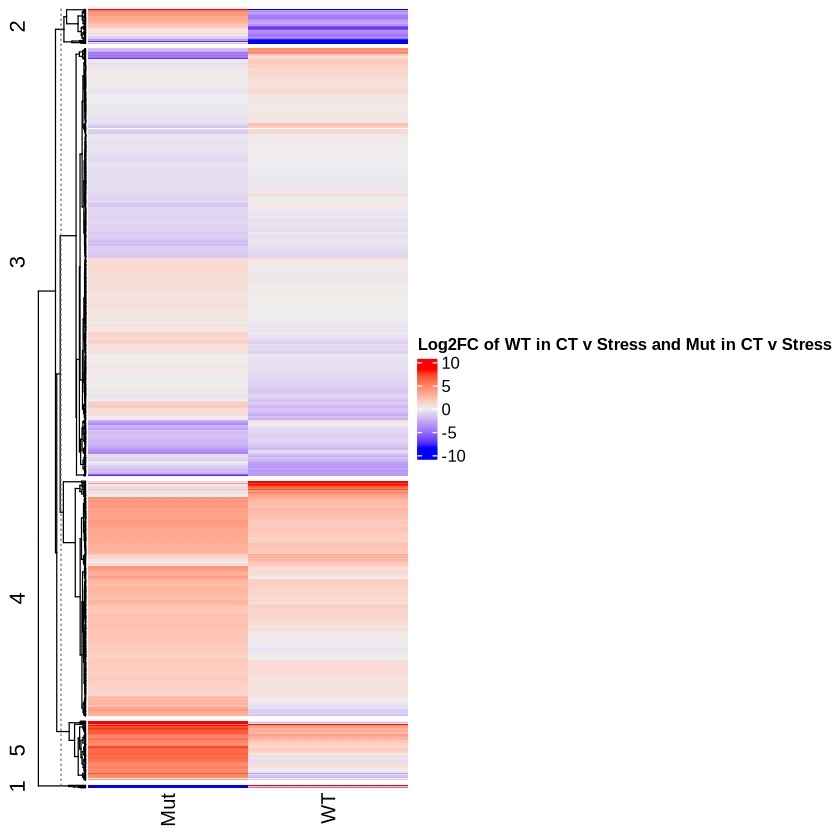

In [26]:
## define int_genes as list of DEGs from interaction term
int_genes= rownames(int_deg_stress )

## logf2FC values of degs from stress interaction term in 
## 1) WT in control vs stress and 2) Mut in control vs stress 

## get log2FC values from appropriate contrast results df and extract the values for the degs from int term
## visualize on heatmap with kmeans clustering of 5 
WtvsMutinput = as.matrix(data.frame(WT=res_WT[int_genes,"log2FoldChange"], Mut=res_mut[int_genes,"log2FoldChange"]))
Heatmap(WtvsMutinput, show_row_names = F, row_km = 5, cluster_rows = T, show_column_dend = F, heatmap_legend_param = list(title= "Log2FC of WT in CT v Stress and Mut in CT v Stress"))

### Upset Plot of distribution of DEGs for all the conditions

In [ ]:
##list of all condition interaction term degs (genes with diff exp in WT and Mut in stress vs control)
input = list(A=row.names(int_deg_A)...)

## get combination matrix of DEGs for all conditions with mode distinct to identify unique # of DEGs
m <- make_comb_mat(input, mode="distinct")

## plot combination matrix on Upset plot 
upset(fromList(input), 
      nintersects = 30, 
      nsets = 7, 
      sets = c("A",...),
      keep.order = T,
      set_size.show = T,
      order.by = "freq", 
      decreasing = T, 
      text.scale = 0.8, 
      point.size = 2.8, 
      line.size = 1,
      queries = list(
        list(query = intersects,params = list("stress"),active = T, query.name = "stress condition", 
        color = "red"),
        list(query = intersects,params = list(), active=T, 
        color = "cyan", query.name = "All conditions")),
      query.legend = "bottom")


## Functional Analysis 

In [36]:
## load libraries for functional analysis
library(clusterProfiler)
library(enrichplot)
library(org.At.tair.db)
keytypes(org.At.tair.db)
require(DOSE)



clusterProfiler v4.12.6 Learn more at https://yulab-smu.top/contribution-knowledge-mining/

Please cite:

T Wu, E Hu, S Xu, M Chen, P Guo, Z Dai, T Feng, L Zhou, W Tang, L Zhan,
X Fu, S Liu, X Bo, and G Yu. clusterProfiler 4.0: A universal
enrichment tool for interpreting omics data. The Innovation. 2021,
2(3):100141


Attaching package: 'clusterProfiler'


The following object is masked from 'package:IRanges':

    slice


The following object is masked from 'package:S4Vectors':

    rename


The following object is masked from 'package:stats':

    filter


Loading required package: AnnotationDbi


Attaching package: 'AnnotationDbi'


The following object is masked from 'package:clusterProfiler':

    select


The following object is masked from 'package:dplyr':

    select






[1] "ARACYC"       "ARACYCENZYME" "ENTREZID"     "ENZYME"       "EVIDENCE"    
 [6] "EVIDENCEALL"  "GENENAME"     "GO"           "GOALL"        "ONTOLOGY"    
[11] "ONTOLOGYALL"  "PATH"         "PMID"         "REFSEQ"       "SYMBOL"      
[16] "TAIR"

Loading required package: DOSE

DOSE v3.30.5  For help: https://yulab-smu.top/biomedical-knowledge-mining-book/

If you use DOSE in published research, please cite:
Guangchuang Yu, Li-Gen Wang, Guang-Rong Yan, Qing-Yu He. DOSE: an R/Bioconductor package for Disease Ontology Semantic and Enrichment analysis. Bioinformatics 2015, 31(4):608-609




In [ ]:
fig.width = 8
GOgene_list = list(MUTvWT_in_CT = row.names(deg_WTvMut),...)

all_GO= compareCluster(geneCluster = gene_list, fun = "enrichGO", OrgDb = "org.At.tair.db", keyType = "TAIR",ont = "BP", pvalueCutoff = 1)
                 
dotplot(all_GO, showCategory= 20,font.size = 10, label_format=50)
                 

### Part II - Arabidopsis Stress GRN

#### The aim of the following analysis is to identify the network of 'X' TF and find its targets and co-regulators. 

### Get Transcription Factors and targets of Arabidopsis 
Two sources: 
1) from DAP-seq data: experimentally identified (does not have X data)
2) from PlantTFDB: computationally identified (has X data)

In [ ]:
## Extract DAP-seq data from Plant Cistrome DB (http://neomorph.salk.edu/dap_web/pages/browse_table_aj.php)

## 1) Download target genes from db website >> download folder dap_data_v4

## 2) Extract data with following python script 
## read data from .txt files in each folder of genes folder in dap_data_v4 
## and compile into output file target_gene_list.txt

import os 

dap_dir = os. listdir("./dap_data_v4/genes/")
print(dap_dir)

out = open("target_gene_list.txt", "w")
path= "./dap_data_v4/genes"
for root, dirs, files in os. walk(path):
    for file in files: 
        if(file.endswith(".txt")):
            f = open(os.path.join(root, file))
            f_contents= f.read()
            out. write(f_contents + "\n")
out.close()

In [ ]:
## Get TF data from Plant TF DB (https://planttfdb.gao-lab.org/download.php)
## download TF list for Arabidopsis Thaliana >> output Ath_TF_list.txt


In [1]:
library(GENIE3)

In [2]:
## with Dap-seq data
## run genie3 to infer interaction of TF - target gene 
## get linkedList to get interaction prediction stregth (weight) of all edges 

## GENIE3 with exprmat and Dap TF and targets
weightMat = GENIE3(exprMat, regulators = dap_regulators, targets = dap_targets, nCores=4)
dim(weightMat)

linkList = getLinkList(weightMat)
linkList

## write linkedlist into csv file, download and visualize locally with Cytoscape
write.csv(linkList, file="dap_linkList.csv")

ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'exprMatrix' in selecting a method for function 'GENIE3': object 'exprMat' not found


In [ ]:
## with plantTFDB (web) data
## run genie3 to infer interaction of TF - target gene 
## get linkedList to get interaction prediction stregth (weight) of all edges 

## GENIE3 with exprmat and plantTFDB TF
weightMat = GENIE3(exprMat, regulators = web_regulators, nCores=4)
dim(weightMat)

linkList = getLinkList(weightMat)
linkList

## write linkedlist into csv file, download and visualize locally with Cytoscape
write.csv(linkList, file="web_linkList.csv")

### WCGNA (Weighted gene co-expression network analysis)

Identify highly correlated genes to elucidate co-regulatory network of X

In [1]:
## packages for WGCNA
BiocManager::install('WGCNA')
BiocManager::install('flashClust')

library(WGCNA)
library(flashClust)


'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.r-project.org

Bioconductor version 3.19 (BiocManager 1.30.25), R 4.4.1 (2024-06-14)

Installing package(s) 'WGCNA'

also installing the dependencies ‘checkmate’, ‘rstudioapi’, ‘htmlTable’, ‘Formula’, ‘iterators’, ‘dynamicTreeCut’, ‘fastcluster’, ‘Hmisc’, ‘impute’, ‘foreach’, ‘doParallel’, ‘preprocessCore’





The downloaded binary packages are in
	/var/folders/c0/l5k350ys37l4sj3vhs0nr12h0000gn/T//Rtmp7Pk9no/downloaded_packages


Old packages: 'abind', 'askpass', 'bit', 'bit64', 'bitops', 'caTools',
  'commonmark', 'curl', 'data.table', 'DOSE', 'dotCall64', 'enrichplot',
  'evaluate', 'FNN', 'fontawesome', 'fs', 'future.apply', 'GenomicRanges',
  'ggfun', 'ggrepel', 'glue', 'gplots', 'graphlayouts', 'gtable', 'httr2',
  'igraph', 'jsonlite', 'knitr', 'Matrix', 'matrixStats', 'mvtnorm', 'openssl',
  'parallelly', 'patchwork', 'progressr', 'R.oo', 'Rcpp', 'RcppArmadillo',
  'reticulate', 'rjson', 'rmarkdown', 'RSQLite', 'spam', 'spatstat.data',
  'spatstat.explore', 'spatstat.geom', 'spatstat.random', 'spatstat.univar',
  'spatstat.utils', 'sys', 'tinytex', 'withr', 'xfun', 'yulab.utils'

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.r-project.org

Bioconductor version 3.19 (BiocManager 1.30.25), R 4.4.1 (2024-06-14)

Installing package(s) 'flashClust'




The downloaded binary packages are in
	/var/folders/c0/l5k350ys37l4sj3vhs0nr12h0000gn/T//Rtmp7Pk9no/downloaded_packages


Old packages: 'abind', 'askpass', 'bit', 'bit64', 'bitops', 'caTools',
  'commonmark', 'curl', 'data.table', 'DOSE', 'dotCall64', 'enrichplot',
  'evaluate', 'FNN', 'fontawesome', 'fs', 'future.apply', 'GenomicRanges',
  'ggfun', 'ggrepel', 'glue', 'gplots', 'graphlayouts', 'gtable', 'httr2',
  'igraph', 'jsonlite', 'knitr', 'Matrix', 'matrixStats', 'mvtnorm', 'openssl',
  'parallelly', 'patchwork', 'progressr', 'R.oo', 'Rcpp', 'RcppArmadillo',
  'reticulate', 'rjson', 'rmarkdown', 'RSQLite', 'spam', 'spatstat.data',
  'spatstat.explore', 'spatstat.geom', 'spatstat.random', 'spatstat.univar',
  'spatstat.utils', 'sys', 'tinytex', 'withr', 'xfun', 'yulab.utils'

Loading required package: dynamicTreeCut

Loading required package: fastcluster


Attaching package: ‘fastcluster’


The following object is masked from ‘package:stats’:

    hclust





Attaching package: ‘WGCNA’


The following object is masked from ‘package:stats’:

    cor



Attaching package: ‘flashClust’


The following o

WGCNA takes expression counts as input (can take from DESeq2 dds object) but it needs to be normalized so vst counts (vsd object) will be used as input

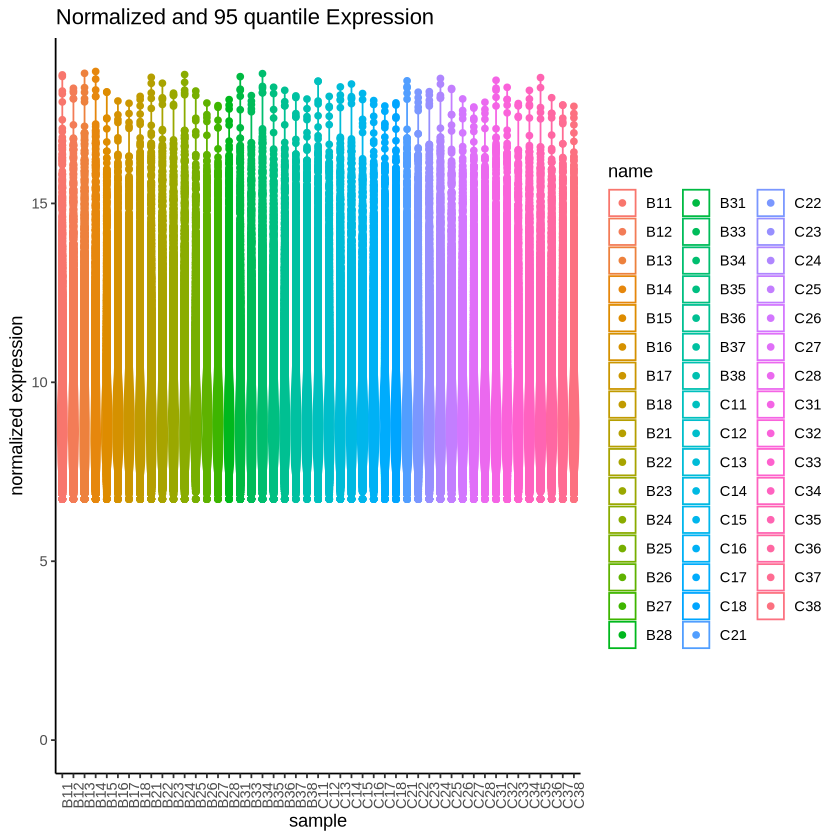

In [45]:
## violin plot to visualize normalization of sample counts 
expr_normalized_df <- data.frame(assay(vsd_original)) %>%
  mutate(
    Gene_id = row.names(vsd_original)
  ) %>%
  pivot_longer(-Gene_id)

expr_normalized_df %>% ggplot(., aes(x = name, y = value, color=name)) +
  geom_violin() +
  geom_point() +
  theme_classic() +
  theme(axis.text.x = element_text( angle = 90)) +
  ylim(0, NA) +
  labs(
    title = "Normalized and 95 quantile Expression",
    x = "sample",
    y = "normalized expression")


 Flagging genes and samples with too many missing values...
  ..step 1


            Length Class  Mode   
goodGenes   19219  -none- logical
goodSamples    47  -none- logical
allOK           1  -none- logical

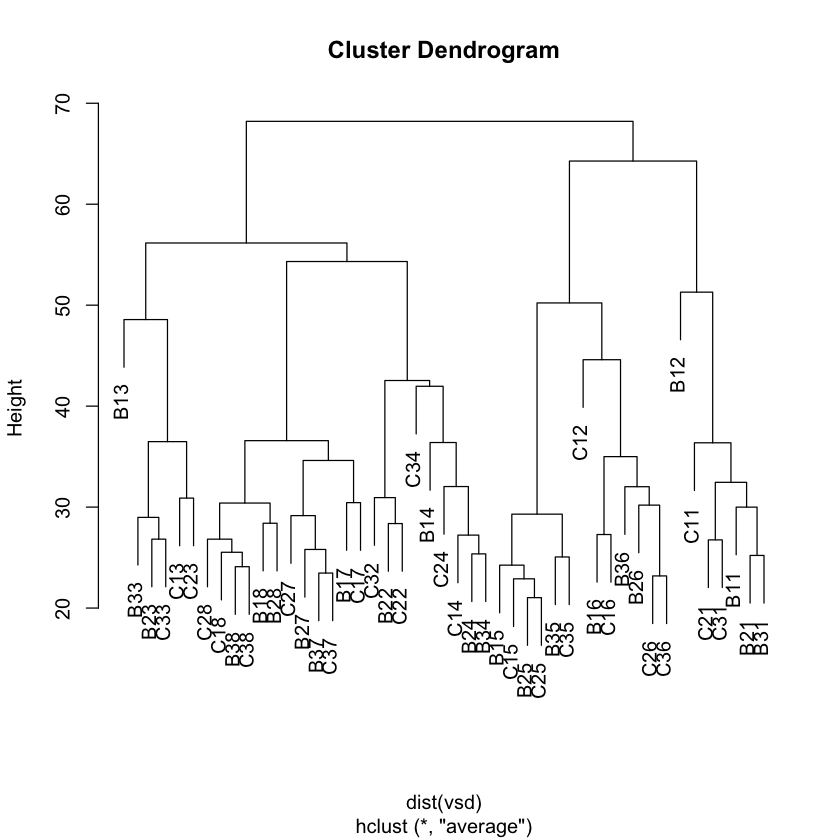

In [2]:
load("vsd.RDS")

## get good Sample genes -- idenifies sample with many outliers
gsg=goodSamplesGenes(vsd)
summary(gsg)

## hierarchical clustering of vsd and plot to see which how samples can group
htree= hclust(dist(vsd), method="average")
plot(htree)

Select parameters to run with WGCNA: 

For network/matrix type -- will set to "unsigned" which means that the both positively and negatively correlated will be considered. 

For the correlation threshold (which are significant) -- will use a soft threshold method which takes all values to a exponent (power) so that values are inflated and noise from weak correlations is decreased

Allowing parallel execution with up to 3 working processes.
   Power SFT.R.sq  slope truncated.R.sq mean.k. median.k. max.k.
1      1   0.7230  2.100          0.946 5220.00  5390.000   7440
2      2   0.0292  0.165          0.722 2130.00  2160.000   4070
3      3   0.2870 -0.562          0.807 1060.00  1020.000   2610
4      4   0.5530 -0.932          0.906  592.00   531.000   1830
5      5   0.6740 -1.160          0.948  360.00   296.000   1360
6      6   0.7460 -1.330          0.969  233.00   174.000   1060
7      7   0.7920 -1.440          0.984  157.00   106.000    846
8      8   0.8220 -1.530          0.986  111.00    66.400    695
9      9   0.8420 -1.600          0.983   80.00    42.800    582
10    10   0.8620 -1.640          0.982   59.40    28.200    496
11    12   0.8920 -1.680          0.980   34.90    12.800    374
12    14   0.9170 -1.700          0.976   21.90     6.200    294
13    16   0.9330 -1.690          0.969   14.40     3.130    238
14    18   0.9470 -1.680      

Power,SFT.R.sq,slope,truncated.R.sq,mean.k.,median.k.,max.k.,model_fit
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.72320778,2.1011125,0.9455257,5222.217104,5386.1808569,7438.7884,-0.72320778
2,0.02917939,0.1651032,0.7222570,2130.478555,2156.7965440,4071.3717,-0.02917939
3,0.28662115,-0.5624353,0.8066960,1057.602123,1019.9657935,2609.5265,0.28662115
4,0.55325786,-0.9317838,0.9064397,592.088623,530.6871959,1830.1270,0.55325786
5,0.67424313,-1.1614919,0.9476048,359.970928,296.4649750,1361.6747,0.67424313
6,0.74564968,-1.3307538,0.9694815,232.516624,173.9426981,1056.7185,0.74564968
7,0.79172509,-1.4380995,0.9839380,157.358892,105.9569850,846.4797,0.79172509
8,0.82156181,-1.5272445,0.9859537,110.526913,66.3755156,695.1046,0.82156181
9,0.84204455,-1.5955621,0.9828766,80.030713,42.7773342,582.3184,0.84204455


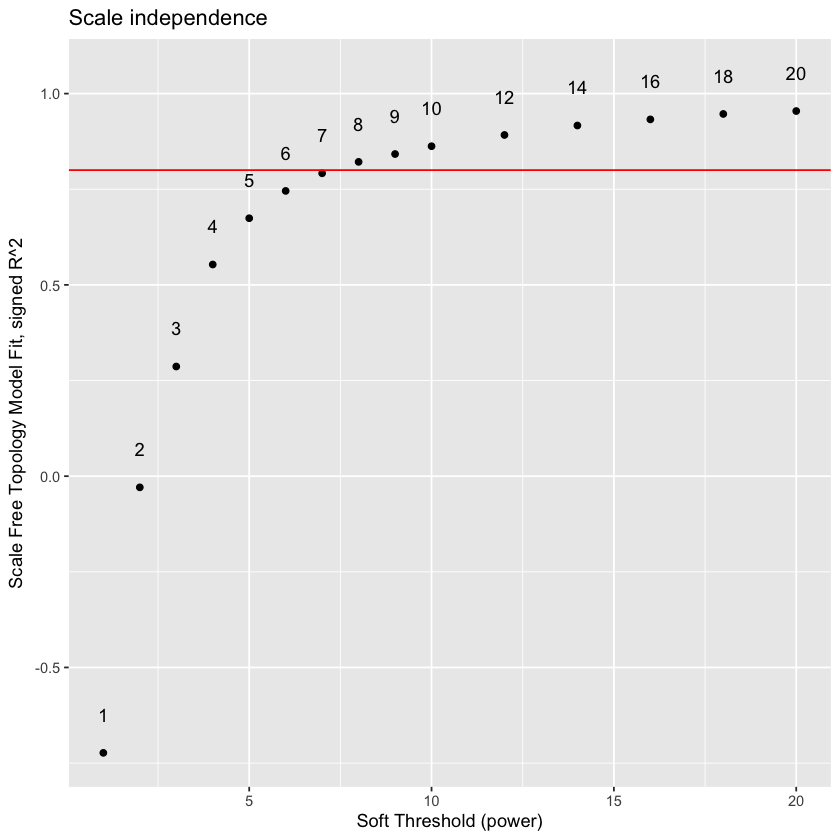

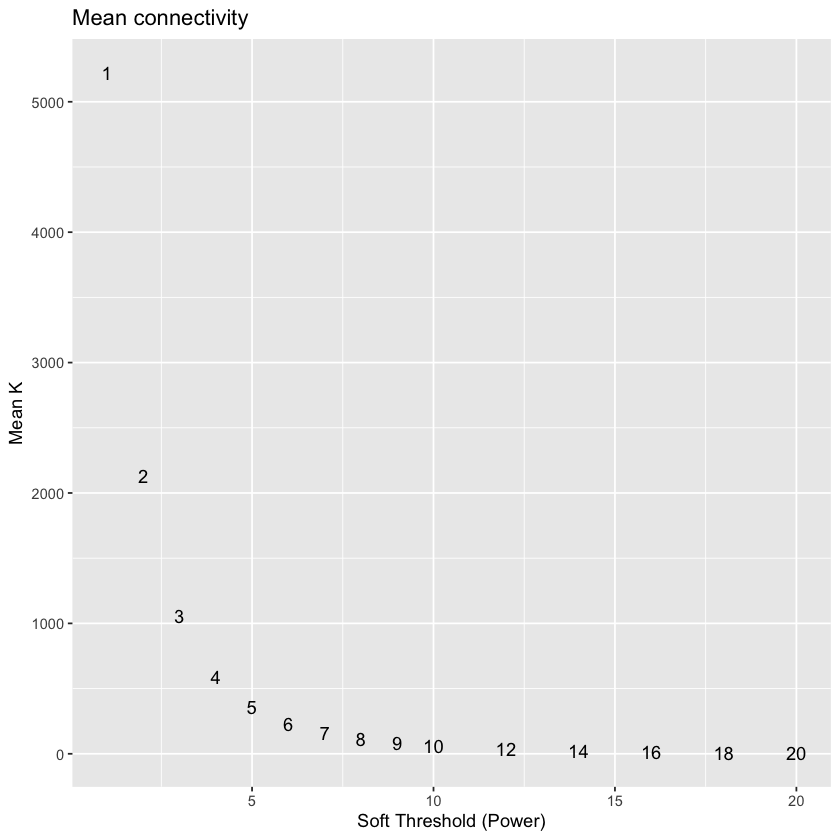

In [8]:
## determine soft threshold (power)

enableWGCNAThreads()

## run WGCNA pickSoftThreshold command to see the impact of using different powers on the data
sft = pickSoftThreshold(vsd, dataIsExpr = T) ##unsigned network

## add col model_fit - signed r2
sft_df= data.frame(sft$fitIndices) %>%
  dplyr::mutate(model_fit = -sign(slope) * SFT.R.sq)

sft_df

##plot fit of model for each power and k.means to select appropriate power val for soft threshold 
ggplot(sft_df, aes(x = Power, y = model_fit, label = Power)) +
  geom_point() +
  geom_text(nudge_y = 0.1) +
  geom_hline(yintercept = 0.80, col = "red") + #plot what WGCNA recommends as an R^2 cutoff
  #ylim(c(min(sft_df$model_fit), 1.05)) +
  xlab("Soft Threshold (power)") +
  ylab("Scale Free Topology Model Fit, signed R^2") +
  ggtitle("Scale independence") #+ theme_classic()

ggplot(sft_df, aes(x= Power, y= mean.k., label = Power)) +
  geom_text(nudge_y = 0.1) +
  xlab("Soft Threshold (Power)") +
  ylab("Mean K") +
  ggtitle("Mean connectivity") #+ theme_classic()
 

Chose 8 as power or soft threshold -- above 0.8 R2 (as recommended by WGCNA) and has a greater means.k (more corr) 

In [ ]:
## Run WCGNA automated command which will construct adjacency matrix from the expression counts, topological matrix (TOM) and get TOM dissimilairty

## unsigned network and TOM with all genes (vsd) using power 8
bwnet= blockwiseModules(vsd,
  maxBlockSize = 20000, # What size chunks (how many genes) the calculations should be run in
  networkType = "unsigned",
  TOMType = "unsigned", # topological overlap matrix - takes into account pos/neg sign 
  power = 8, # soft threshold for network construction
  numericLabels = TRUE, # Let's use numbers instead of colors for module labels
  randomSeed = 1234, # some randomness associated with  calculation so  should set seed
  saveTOMs = T,
  saveTOMFileBase = "bw_Tom", 
  verbose=3,
  deepSplit = 2,
  pamRespectsDendro = F, ##defaults
  reassignThreshold = 0,
  mergeCutHeight = 0.25,
  nThreads = 47
)

## NOTE: above command takes 1+ hr to run so save and load 

save(bwnet, file="bwnet.RDS")

ModuleColor,GeneCount
<fct>,<int>
turquoise,3059
blue,2657
brown,1904
yellow,1832
green,1680
red,1192
black,1022
pink,1011
magenta,863


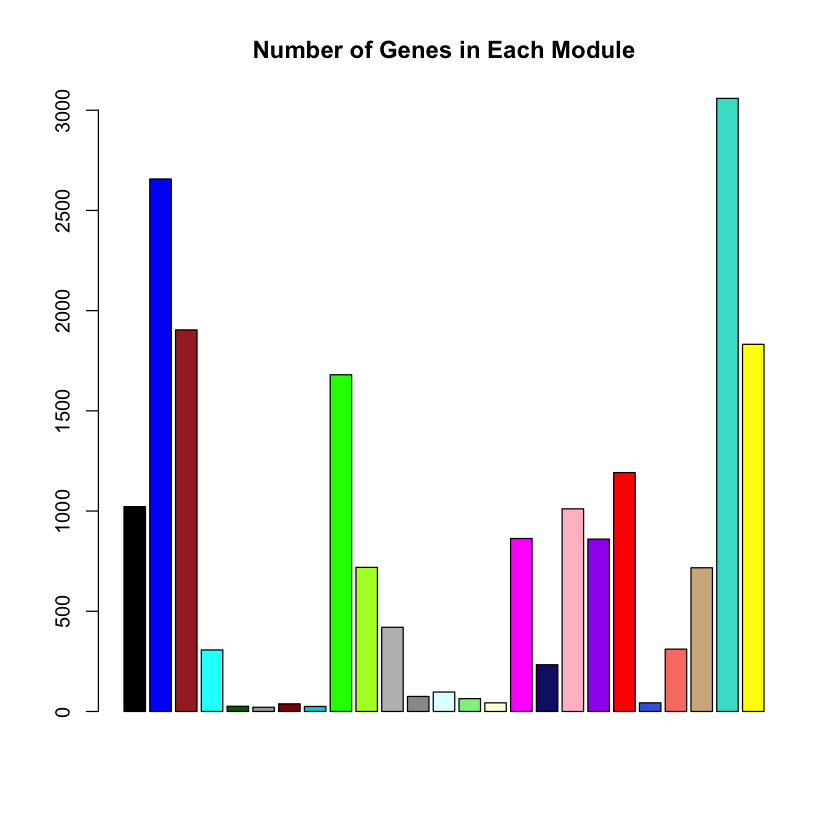

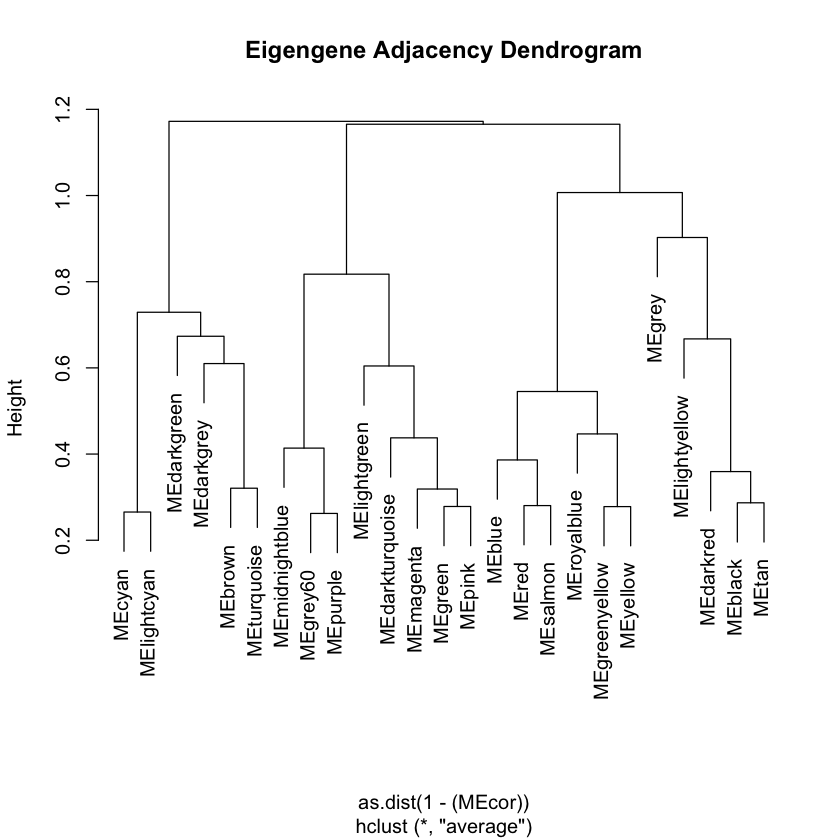

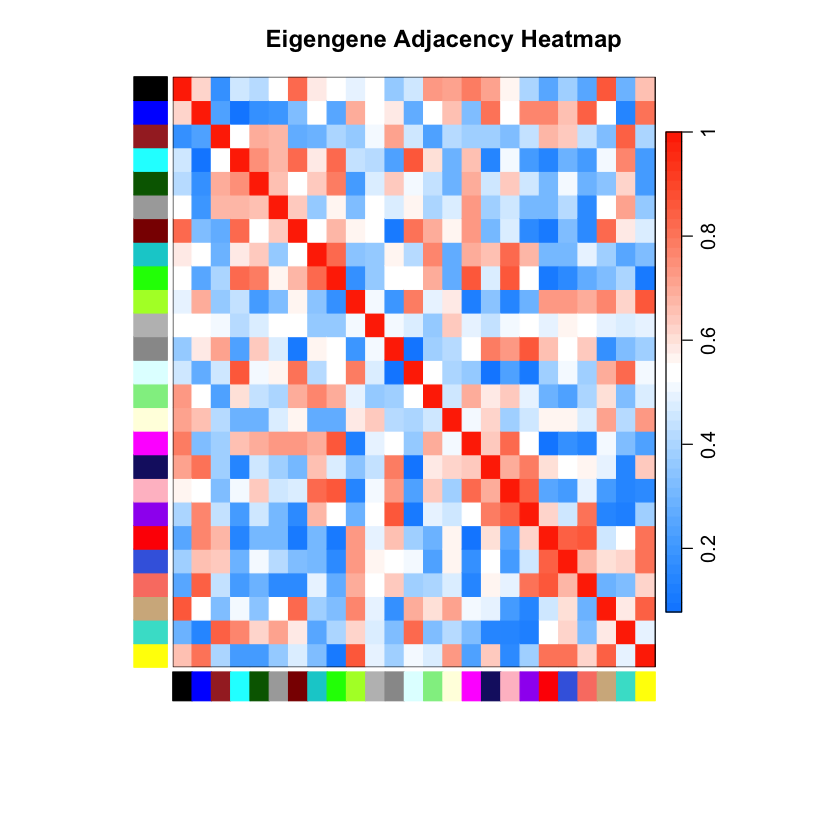

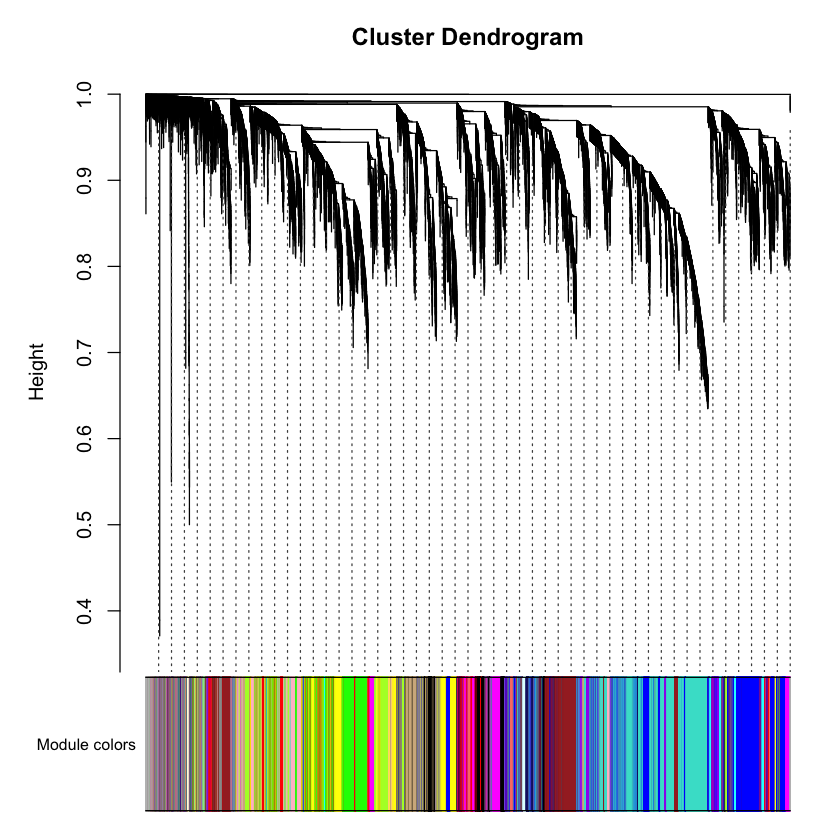

In [9]:
## load WCGNA matrix bwnet
load("bwnet.RDS")

## get module and colors
moduleColors = labels2colors(bwnet$colors)

## how many genes per module
geneCounts_df <- as.data.frame(table(moduleColors))
colnames(geneCounts_df) <- c("ModuleColor", "GeneCount")
geneCounts_df %>% dplyr::arrange(desc(GeneCount))
barplot(table(moduleColors), main = "Number of Genes in Each Module", col = names(table(moduleColors)), xaxt="n")

## get eigengenes (think PCA -- first dimension, genes that represents module)
MEs = moduleEigengenes(vsd, colors = moduleColors)$eigengenes

## cluster module eigengenes by correlation 
MEcor = cor(MEs)
#MEdist <- 1 - MEcor  # Distance = 1 - adjacency
MEtree = hclust(as.dist(1- (MEcor)), method = "average")
plot(MEtree, main = "Eigengene Adjacency Dendrogram")

MEadj = (1 + MEcor) / 2  # Scale correlations to (0, 1)
labeledHeatmap(
  Matrix = MEadj,
  xLabels = colnames(MEadj),
  yLabels = colnames(MEadj),
  main = "Eigengene Adjacency Heatmap",
  colorLabels = FALSE,
  colors = blueWhiteRed(50)  # Use a diverging color scale
)

# Plot the dendrogram and the module colors underneath
plotDendroAndColors(
  bwnet$dendrograms[[1]],
  moduleColors[bwnet$blockGenes[[1]]],
  "Module colors",
  dendroLabels = FALSE,
  hang = 0.03,
  addGuide = TRUE,
  guideHang = 0.05 )